<h2>Part 3: Using classification to predict weather</h2>

<h3>Classification technique: Logistic Regression</h3>

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFECV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [2]:
# Import data and process as for the decision tree
BOM_data = pd.read_csv('BOM_processed.csv')


In [3]:
# Drop redundant variables
BOM_data = BOM_data.drop(['Unnamed: 0','Date','Day','MinTemp','MaxTemp','Rainfall','Evaporation','Sunshine','WindGustDir','WindGustSpeed',
                          'WindDir9am','WindDir3pm','WindSpeed9am','WindSpeed3pm','Humidity3pm','Pressure3pm','Cloud3pm',
                          'Temp3pm','RainLastWeek','RainToday','ENSO','Year','Location'], axis=1)

In [4]:
BOM_data = BOM_data.dropna()

In [5]:
y = BOM_data['RainTomorrow'] # Target variable
X = BOM_data.drop(['RainTomorrow'], axis=1)

In [6]:
X_mat = X.to_numpy()

In [7]:
rs = 10

# Split into 70% training and 30% test
X_train, X_test, y_train, y_test = train_test_split(X_mat, y, test_size=0.2, stratify=y, random_state=rs)

In [8]:
# Standardise data ready for logistic regression
# initialise a standard scaler object
scaler = StandardScaler()

# visualise min, max, mean and standard dev of data before scaling
print("Before scaling\n-------------")
for i in range(5):
    col = X_train[:,i]
    print("Variable #{}: min {}, max {}, mean {:.2f} and std dev {:.2f}".
          format(i, min(col), max(col), np.mean(col), np.std(col)))

# learn the mean and std.dev of variables from training data
# then use the learned values to transform training data
X_train = scaler.fit_transform(X_train, y_train)

print("After scaling\n-------------")
for i in range(5):
    col = X_train[:,i]
    print("Variable #{}: min {}, max {}, mean {:.2f} and std dev {:.2f}".
          format(i, min(col), max(col), np.mean(col), np.std(col)))

# use the statistic that you learned from training to transform test data
# NEVER learn from test data, this is supposed to be a set of dataset
# that the model has never seen before
X_test = scaler.transform(X_test)

Before scaling
-------------
Variable #0: min 1.0, max 12.0, mean 6.40 and std dev 3.43
Variable #1: min 0.0, max 100.0, mean 68.76 and std dev 18.71
Variable #2: min 980.5, max 1041.0, mean 1017.70 and std dev 7.12
Variable #3: min 0.0, max 9.0, mean 4.46 and std dev 2.36
Variable #4: min -1.7, max 40.2, mean 17.11 and std dev 6.33
After scaling
-------------
Variable #0: min -1.5733366976432712, max 1.6329797558296884, mean 0.00 and std dev 1.00
Variable #1: min -3.6759823375645175, max 1.6700772002852804, mean -0.00 and std dev 1.00
Variable #2: min -5.223109635158732, max 3.27201429211263, mean -0.00 and std dev 1.00
Variable #3: min -1.8921588120969484, max 1.9247892783762366, mean -0.00 and std dev 1.00
Variable #4: min -2.9733783565384893, max 3.6491249810881907, mean -0.00 and std dev 1.00


In [9]:
# initiate a model object (with random state to ensure consistent result) and fit it to the training dataset. 

model = LogisticRegression(random_state=rs)

# fit it to training data
model.fit(X_train, y_train)

LogisticRegression(random_state=10)

In [10]:
# Check the accuracy of the model
print("Train accuracy:", model.score(X_train, y_train))
print("Test accuracy:", model.score(X_test, y_test))

# classification report on test data
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

Train accuracy: 0.7962879915200685
Test accuracy: 0.7982795874271271
              precision    recall  f1-score   support

         0.0       0.82      0.95      0.88     18954
         1.0       0.63      0.27      0.38      5575

    accuracy                           0.80     24529
   macro avg       0.72      0.61      0.63     24529
weighted avg       0.77      0.80      0.77     24529



In [11]:
# Determine which variables were most importnat in the model
# A positive value indicates a positive relationship between the variable and RainTomorrow
# A negative value indicates a negative relationship between the variable and RainTomorrow
# grab feature importances from the model and feature name from the original X
coef = model.coef_[0]
feature_names = X.columns

# sort them out in descending order
indices = np.argsort(np.absolute(coef))
indices = np.flip(indices, axis=0)

# limit to 20 features, you can leave this out to print out everything
indices = indices[:20]

for i in indices:
    print(feature_names[i], ':', coef[i])

Humidity9am : 0.7345702779045097
Pressure9am : -0.6715245870447071
Cloud9am : 0.4375000481064794
Month : 0.11173956293100079
Temp9am : 0.06483740613305874


In [12]:
# Humidity and pressure are the most important variables

In [13]:
# Now try to optimise the model using GridSearchCV
# Will tune the hyperparameter: regularisation strength ('C')
# Regularisation is a technique used to prevent overfitting in regression models
# Also test a few different soler algortihms

# grid search CV
params = {'C': [pow(10, x) for x in range(-6, 4)],
         'solver': ['lbfgs', 'liblinear', 'newton-cg']}

# use all cores to tune logistic regression with C parameter
cv = GridSearchCV(param_grid=params, estimator=LogisticRegression(random_state=rs),return_train_score=True, cv=10, n_jobs=-1)
cv.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=LogisticRegression(random_state=10), n_jobs=-1,
             param_grid={'C': [1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10,
                               100, 1000],
                         'solver': ['lbfgs', 'liblinear', 'newton-cg']},
             return_train_score=True)

In [22]:
# Show the best parameters
print(cv.best_params_)

{'C': 0.001, 'solver': 'lbfgs'}


In [23]:
result_set=cv.cv_results_

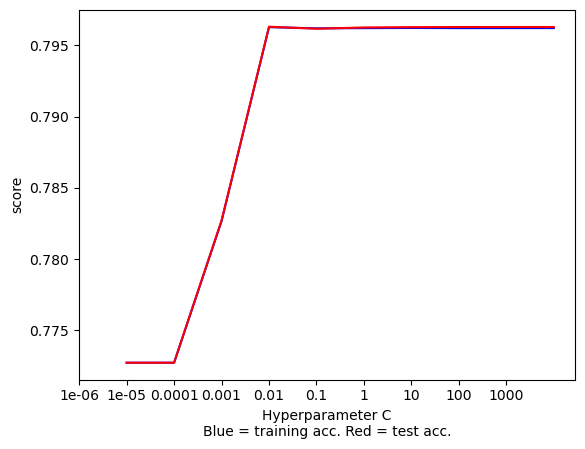

In [26]:
# Show the mean values for all of the splits
train_result = result_set['mean_train_score']
test_result = result_set['mean_test_score']

C_train = []
C_test = []
index_
for i in range(len(index_)):
    C_train.append(train_result[index_[i]])
    C_test.append(test_result[index_[i]])
plt.plot(range(1, len(C_train)+1), C_train, 'b', range(1,len(C_test)+1), C_test, 'r')
plt.xlabel('Hyperparameter C\nBlue = training acc. Red = test acc.')
plt.xticks(range(0, len(C_train)),[pow(10, x) for x in range(-6, 4)])
plt.ylabel('score')
plt.show()

In [29]:
# The blue and red curves are right on top of each other
# The optimal regularisation value is 0.001. After this point, neither the test or training accuracy increases
# Run the model again using this parameter

In [30]:
print(cv.best_params_)

{'C': 0.001, 'solver': 'lbfgs'}


In [31]:
# Re-create model with optimised parameters
model_optimised = LogisticRegression(random_state=rs, C=0.001, solver='lbfgs')

# fit it to training data
model_optimised.fit(X_train, y_train)

LogisticRegression(C=0.001, random_state=10)

In [32]:
# Check the accuracy of the model
print("Train accuracy:", model_optimised.score(X_train, y_train))
print("Test accuracy:", model_optimised.score(X_test, y_test))

# classification report on test data
y_pred = model_optimised.predict(X_test)
print(classification_report(y_test, y_pred))

Train accuracy: 0.7961860692663636
Test accuracy: 0.7978719067226548
              precision    recall  f1-score   support

         0.0       0.81      0.96      0.88     18954
         1.0       0.65      0.24      0.35      5575

    accuracy                           0.80     24529
   macro avg       0.73      0.60      0.62     24529
weighted avg       0.77      0.80      0.76     24529



In [33]:
# Determine which variables were most important in the optimised model
# A positive value indicates a positive relationship between the variable and RainTomorrow
# A negative value indicates a negative relationship between the variable and RainTomorrow
# grab feature importances from the model and feature name from the original X
coef = model_optimised.coef_[0]
feature_names = X.columns

# sort them out in descending order
indices = np.argsort(np.absolute(coef))
indices = np.flip(indices, axis=0)

# limit to 20 features, you can leave this out to print out everything
indices = indices[:20]

for i in indices:
    print(feature_names[i], ':', coef[i])

Humidity9am : 0.655997016434469
Pressure9am : -0.6181521400648989
Cloud9am : 0.42184108275100557
Month : 0.09461668338892433
Temp9am : 0.04578702807082163


In [34]:
# Now perform recursive feature elimination to see if removing some variables improves the model

rfe = RFECV(estimator = LogisticRegression(random_state=rs), cv=10)
rfe.fit(X_train, y_train) # run the RFECV

# comparing how many variables before and after
print("Original feature set", X_train.shape[1])
print("Number of features after elimination", rfe.n_features_)

Original feature set 5
Number of features after elimination 4


In [35]:
rfe.cv_results_

{'mean_test_score': array([0.77273376, 0.79421898, 0.79574781, 0.79629822, 0.79626765]),
 'std_test_score': array([3.75931705e-05, 1.57223256e-03, 2.86911557e-03, 3.11604899e-03,
        2.82627189e-03]),
 'split0_test_score': array([0.77272727, 0.79321239, 0.79535263, 0.79433347, 0.79372197]),
 'split1_test_score': array([0.77272727, 0.79290664, 0.79280473, 0.79321239, 0.79280473]),
 'split2_test_score': array([0.77272727, 0.79290664, 0.79331431, 0.79270281, 0.79321239]),
 'split3_test_score': array([0.77272727, 0.79728903, 0.80116184, 0.80116184, 0.80105993]),
 'split4_test_score': array([0.77280603, 0.79288554, 0.7958414 , 0.79624911, 0.79675874]),
 'split5_test_score': array([0.77280603, 0.79675874, 0.79757415, 0.80042809, 0.79961268]),
 'split6_test_score': array([0.77270411, 0.79492406, 0.79971461, 0.80012231, 0.79879727]),
 'split7_test_score': array([0.77270411, 0.79288554, 0.79257976, 0.7934971 , 0.7939048 ]),
 'split8_test_score': array([0.77270411, 0.79461829, 0.79278361, 0.

In [36]:
# Identified that only 4 features are needed for the model
# Transform the original data set to only use the 4 features identified
X_train_sel = rfe.transform(X_train)
X_test_sel = rfe.transform(X_test)

In [38]:
# Run GridSearchCV again to see if we can improve the accuracy
params = {'C': [pow(10, x) for x in range(-6, 4)]}

rfe_cv = GridSearchCV(param_grid=params, estimator=LogisticRegression(random_state=rs), cv=10, n_jobs=-1)
rfe_cv.fit(X_train_sel, y_train)

# test the best model
print("Train accuracy:", rfe_cv.score(X_train_sel, y_train))
print("Test accuracy:", rfe_cv.score(X_test_sel, y_test))

y_pred = rfe_cv.predict(X_test_sel)
print(classification_report(y_test, y_pred))

# print parameters of the best model
print(rfe_cv.best_params_)

Train accuracy: 0.7961758770409931
Test accuracy: 0.7984426597089159
              precision    recall  f1-score   support

         0.0       0.82      0.95      0.88     18954
         1.0       0.63      0.27      0.38      5575

    accuracy                           0.80     24529
   macro avg       0.73      0.61      0.63     24529
weighted avg       0.77      0.80      0.77     24529

{'C': 1}


In [39]:
# Create the model again using the reduced data set and optimised parameters
model_rfe = LogisticRegression(random_state=rs, C=1)

# fit it to training data
model_rfe.fit(X_train_sel, y_train)

LogisticRegression(C=1, random_state=10)

In [40]:
# Check the accuracy of the model
print("Train accuracy:", model_rfe.score(X_train_sel, y_train))
print("Test accuracy:", model_rfe.score(X_test_sel, y_test))

# classification report on test data
y_pred = model_rfe.predict(X_test_sel)
print(classification_report(y_test, y_pred))

Train accuracy: 0.7961758770409931
Test accuracy: 0.7984426597089159
              precision    recall  f1-score   support

         0.0       0.82      0.95      0.88     18954
         1.0       0.63      0.27      0.38      5575

    accuracy                           0.80     24529
   macro avg       0.73      0.61      0.63     24529
weighted avg       0.77      0.80      0.77     24529



In [41]:
# Determine which variables were most important in the feature reduced model
# A positive value indicates a positive relationship between the variable and RainTomorrow
# A negative value indicates a negative relationship between the variable and RainTomorrow
# grab feature importances from the model and feature name from the original X
coef = model_rfe.coef_[0]
feature_names = X.columns

# sort them out in descending order
indices = np.argsort(np.absolute(coef))
indices = np.flip(indices, axis=0)

for i in indices:
    print(feature_names[i], ':', coef[i])

Humidity9am : 0.7043576902130947
Pressure9am : -0.6902147512564842
Cloud9am : 0.43839738417169366
Month : 0.09968839280985385


In [42]:
# Compare the 3 models using area under ROC curve.

y_pred_proba_default = model.predict_proba(X_test)
y_pred_proba_optimised = model_optimised.predict_proba(X_test)
y_pred_proba_rfe = model_rfe.predict_proba(X_test_sel)

roc_index_default = roc_auc_score(y_test, y_pred_proba_default[:, 1])
roc_index_optimised = roc_auc_score(y_test, y_pred_proba_optimised[:, 1])
roc_index_rfe = roc_auc_score(y_test, y_pred_proba_rfe[:, 1])

print("ROC index on test for `default`:", roc_index_default)
print("ROC index on test for `optimised`:", roc_index_optimised)
print("ROC index on test for `rfe`:", roc_index_rfe)

ROC index on test for `default`: 0.777585875835336
ROC index on test for `optimised`: 0.7774371750156504
ROC index on test for `rfe`: 0.7773051773682897


In [43]:
# Prepare for plotting ROC curves
fpr_default, tpr_default, thresholds_default = roc_curve(y_test, y_pred_proba_default[:,1])
fpr_optimised, tpr_optimised, thresholds_optimised = roc_curve(y_test, y_pred_proba_optimised[:,1])
fpr_rfe, tpr_rfe, thresholds_rfe = roc_curve(y_test, y_pred_proba_rfe[:,1])

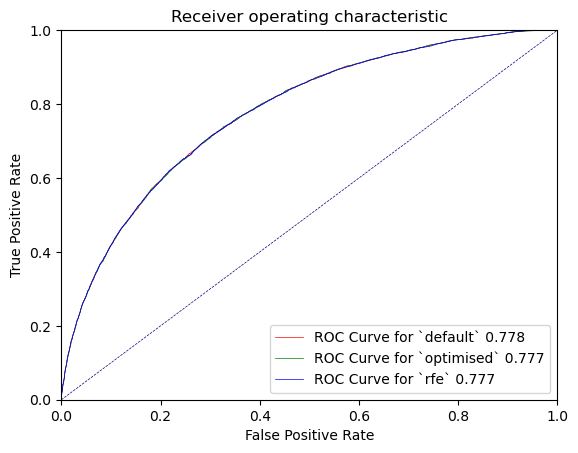

In [44]:
# Plot the ROC curves
plt.plot(fpr_default, tpr_default, label='ROC Curve for `default` {:.3f}'.format(roc_index_default), color='red', lw=0.5)
plt.plot(fpr_optimised, tpr_optimised, label='ROC Curve for `optimised` {:.3f}'.format(roc_index_optimised), color='green', lw=0.5)
plt.plot(fpr_rfe, tpr_rfe, label='ROC Curve for `rfe` {:.3f}'.format(roc_index_rfe), color='blue', lw=0.5)

plt.plot([0, 1], [0, 1], color='navy', lw=0.5, linestyle='--') # Add the diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [45]:
# Store variables so ROC curve can be performed on all predictive modelling trees in a different notebook
fpr_reg = fpr_optimised
tpr_reg = tpr_optimised
thresholds_reg = thresholds_optimised
roc_index_reg = roc_index_optimised

%store fpr_reg
%store tpr_reg
%store thresholds_reg
%store roc_index_reg

Stored 'fpr_reg' (ndarray)
Stored 'tpr_reg' (ndarray)
Stored 'thresholds_reg' (ndarray)
Stored 'roc_index_reg' (float64)
